In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# Enable reproducibility
torch.manual_seed(0)
torch.set_deterministic_debug_mode(0)

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

Dataset Loading

In [2]:
df = pd.read_csv('energy-weather.cvs')
print(df.iloc[0:5, :])

                  time  temperature  pressure  humidity  wind_speed  wind_deg  \
0  2015-01-01 00:00:00      270.475      1001        77           1        62   
1  2015-01-01 01:00:00      270.475      1001        77           1        62   
2  2015-01-01 02:00:00      269.686      1002        78           0        23   
3  2015-01-01 03:00:00      269.686      1002        78           0        23   
4  2015-01-01 04:00:00      269.686      1002        78           0        23   

   rain_1h  clouds_all  generation_solar  
0      0.0           0              49.0  
1      0.0           0              50.0  
2      0.0           0              50.0  
3      0.0           0              50.0  
4      0.0           0              42.0  


In [3]:
# Test code
assert 'df' in locals(), "Variable df is not defined"
np.testing.assert_array_equal(df.columns, ['time', 'temperature', 'pressure','humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'generation_solar'])
np.testing.assert_equal(len(df), 30046)
"ok"

'ok'

Filtering

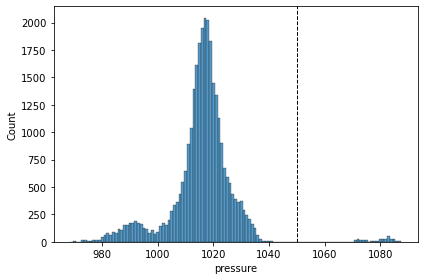

In [4]:
# Histogram of pressure
sns.histplot(data=df["pressure"], discrete=True)
plt.axvline(1050, c="black", linestyle="dashed",linewidth=1)
plt.tight_layout()

In [5]:
#Remove outliers from the Dataset
df_filtered = df[(df["pressure"] <= 1050) & (df["wind_speed"] <= 30)]

In [6]:
# Test code
assert 'df_filtered' in locals(), "Variable df_filtered is not defined"
assert (df_filtered["pressure"] <= 1050).all(), "contains pressure > 1050"
assert (df_filtered["wind_speed"] <= 30).all(), "contains wind_speed > 30"
assert len(df_filtered) == 29731, "Dropped too many rows"
"ok"

'ok'

Introducing Additional Features

In [7]:
# Introduce day feature
df_filtered.loc[:, "day"] = pd.to_datetime(df_filtered['time']).dt.dayofyear

# Introduce generation_solar_categorical feature
df_filtered.loc[:, "generation_solar_categorical"] = pd.cut(df_filtered['generation_solar'], [-np.inf, 160, 1600, np.inf], labels=["low", "medium", "high"], right=False)

c:\Users\Shaunak Kanikar\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\Shaunak Kanikar\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
# Test code
assert all(df_filtered.loc[df_filtered["time"] == "2015-03-02 21:00:00", "day"] == 61)
assert all(df_filtered.loc[df_filtered["time"] == "2018-08-06 11:00:00", "day"] == 218)

assert all(df_filtered["generation_solar_categorical"][df_filtered["generation_solar"] < 160] == "low"), "low label not correct"
assert all(df_filtered["generation_solar_categorical"][(160 <= df_filtered["generation_solar"]) & (df_filtered["generation_solar"] < 1600)] == "medium"), "medium label not correct"
assert all(df_filtered["generation_solar_categorical"][1600 <= df_filtered["generation_solar"]] == "high"), "high label not correct"
"ok"

'ok'

Normalize Data

In [9]:
from sklearn.preprocessing import StandardScaler
# Standardize the dataset
columns =df_filtered.columns.drop(['time', 'generation_solar_categorical']) 
df_filtered[columns] = StandardScaler().fit_transform(df_filtered[columns])

<ipython-input-9-80ea7e0cf47c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[columns] = StandardScaler().fit_transform(df_filtered[columns])
c:\Users\Shaunak Kanikar\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [10]:
# Test code
assert "time" in df_filtered.columns
assert "generation_solar_categorical" in df_filtered.columns

for f in ["temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all", "generation_solar", "day"]:
    assert np.isclose(np.mean(df_filtered[f]), 0), f"{f} is not standardized"
    assert np.isclose(np.std(df_filtered[f]), 1), f"{f} is not standardized"

"ok"

'ok'

Training/Validation Split of the Dataset

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_filtered, test_size=0.1, random_state=42, shuffle=True)

In [12]:
# Test code
assert len(df_train) == 26757, "df_train has wrong size"
assert len(df_val) == 2974, "df_test has wrong size"
assert not df_val.index.isin(df_train.index).any(), "df_test and df_train not disjunct"
assert not df_train.index.isin(df_val.index).any(), "df_test and df_train not disjunct"

# Export data sets
df_train.to_csv("solution/b1e-train.csv", index=False)
df_val.to_csv("solution/b1e-val.csv", index=False)

"ok"

'ok'

Linear Regression with SKlearn

In [13]:
from sklearn.linear_model import LinearRegression

predictors = ["day", "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all"]
target = "generation_solar"

# Fit linear model
model = LinearRegression()
model.fit(df_train[predictors], df_train[target])

LinearRegression()

MSE linear: 0.6762084795995518


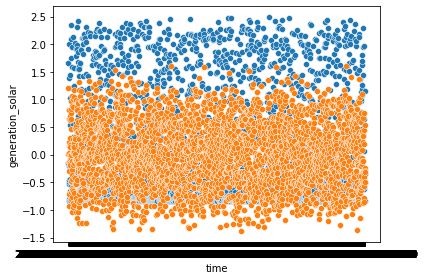

In [14]:
# Test Code
assert "model" in locals(), "Model not implemented"
assert model.coef_.shape == (8, ), "Wrong number of predictors"
_pred = model.predict(df_val[predictors])
sns.scatterplot(x=df_val["time"], y=df_val[target])
sns.scatterplot(x=df_val["time"], y=_pred)
plt.tight_layout()
plt.savefig("solution/b2a.png")
mse = np.mean((_pred - df_val[target])**2)
print(f"MSE linear: {mse}")

Linear regression with non-linear basis functions

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial feature transformation
poly = PolynomialFeatures(2)

# Fit linear model
model_poly = LinearRegression()
model_poly.fit(poly.fit_transform(df_train[predictors]), df_train[target])

LinearRegression()

MSE poly: 0.6239558111293099


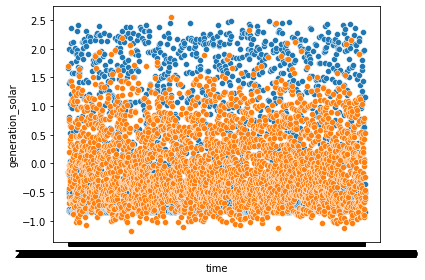

In [16]:
# Test Code
assert "model_poly" in locals(), "model_poly not implemented"
_pred = model_poly.predict(poly.transform(df_val[predictors]))
sns.scatterplot(x=df_val["time"], y=df_val[target])
sns.scatterplot(x=df_val["time"], y=_pred)
plt.tight_layout()
plt.savefig("solution/b2b.png")
mse = np.mean((_pred - df_val[target])**2)
print(f"MSE poly: {mse}")

Classification with Sklearn

In [17]:
from sklearn.linear_model import RidgeClassifier

target = "generation_solar_categorical"

# Fit classifier
model_cls = RidgeClassifier().fit(df_train[predictors], df_train[target])

In [18]:
# Test Code
assert "model_cls" in locals(), "model_cls not implemented"
from sklearn.metrics import classification_report
print(classification_report(df_val[target], model_cls.predict(df_val[predictors]), digits=4))

              precision    recall  f1-score   support

        high     0.6033    0.7955    0.6862      1017
         low     0.5589    0.6915    0.6181       995
      medium     0.5124    0.2141    0.3021       962

    accuracy                         0.5726      2974
   macro avg     0.5582    0.5670    0.5355      2974
weighted avg     0.5590    0.5726    0.5392      2974



Modelling with Pytorch

In [19]:
# Build data loaders for PyTorch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

predictors = ["day", "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all"]

x_train = torch.tensor(df_train[predictors].values,  dtype=torch.float)
x_val = torch.tensor(df_val[predictors].values,  dtype=torch.float)

y_train = torch.tensor(df_train[["generation_solar"]].values,  dtype=torch.float)
y_val = torch.tensor(df_val[["generation_solar"]].values,  dtype=torch.float)


y_train_cat = torch.tensor(df_train["generation_solar_categorical"].cat.codes.values.copy(),  dtype=torch.int64)
y_val_cat = torch.tensor(df_val["generation_solar_categorical"].cat.codes.values.copy(),  dtype=torch.int64)


# For regression
dataset = TensorDataset(x_train, y_train)

# For classification
dataset_cat = TensorDataset(x_train, y_train_cat)

Building Network

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Create layers
        self.fc1 = nn.Linear(8, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        # Forward pass
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [21]:
# Test code
np.testing.assert_array_equal([p.nelement() for p in net.parameters()], [80, 10, 100, 10, 10, 1])
np.testing.assert_array_equal(net(torch.zeros(32, 8)).shape, [32, 1])
"ok"

'ok'

Regression

MSE 0.55/0.57: 100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


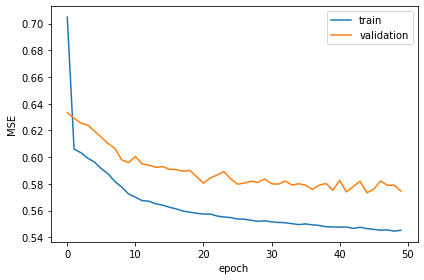

In [22]:
# Tune typerparameters 
learn_rate = 3e-4
epochs = 50
batch_size = 64

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)

    def forward(self, x):
        
        x = torch.nn.Tanh()(self.fc1(x))
        x = torch.nn.Tanh()(self.fc2(x))
        x = torch.nn.Tanh()(self.fc3(x))
        x = torch.nn.Dropout(0.05)(x)
        x = torch.nn.Tanh()(self.fc4(x))
        x = torch.nn.Dropout(0.03)(x)
        x = torch.nn.Tanh()(self.fc5(x))
        x = torch.nn.Dropout(0.01)(x)
        x = torch.nn.LeakyReLU(0.5)(self.fc6(x))
        x = torch.nn.Dropout(0.005)(x)
        x = self.fc7(x)
        return x

net = Net()


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.shape[0]
        losses.append([running_loss / len(dataset), criterion(net(x_val), y_val).item()])
        pbar.set_description(f"MSE {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("solution/b3b.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b3b.png")

Classification

Loss 0.62/0.63: 100%|██████████| 80/80 [02:30<00:00,  1.88s/it]


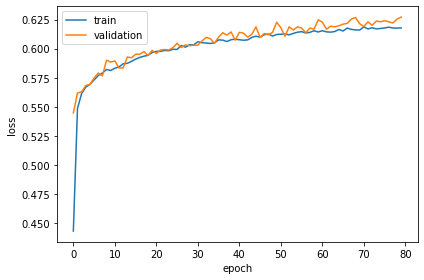

In [23]:
# Tune typerparameters 
learn_rate = 8e-5
epochs = 80
batch_size = 32

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 3)

    def forward(self, x):
        x = torch.nn.LeakyReLU(0.05)(self.fc1(x))
        x = torch.nn.LeakyReLU(0.05)(self.fc2(x))
        x = torch.nn.LeakyReLU(0.2)(self.fc3(x))
        x = torch.nn.Dropout(0.05)(x)
        x = torch.nn.LeakyReLU(0.3)(self.fc4(x))
        x = torch.nn.Dropout(0.03)(x)
        x = torch.nn.LeakyReLU(0.5)(self.fc5(x))
        x = torch.nn.Dropout(0.01)(x)
        x = self.fc6(x)
        return x
    
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)
dataloader_cat = DataLoader(dataset_cat, batch_size=batch_size, shuffle=True)

losses=[]
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader_cat):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += torch.sum((torch.argmax(outputs, dim=1) == labels))  # changed 2021-01-08: Fixed accuracy computation
        losses.append([running_loss / len(dataset_cat), torch.sum((torch.argmax(net(x_val), dim=1) == y_val_cat)) / len(x_val)])  # changed 2021-01-08: Fixed accuracy computation
        pbar.set_description(f"Loss {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("solution/b3c.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b3c.png")

The First model (trained with SKlearn) performed poorer than the Second model (trained with Torch) from the accuracy point of view.
In a sense, the basis functions in the First model are chosen by us. However, the basis functions in the Second model are learned by the model itself. Therefore, the Second model could learn the basis functions so as to map the data X to the space where model could make better classification. That's why we get better performance in the Second model.